### Custom embedder for parametric UMAP. 
This notebook shows you how to run a UMAP projection with a custom embedder. 

In [1]:
%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/opt/conda/envs/umap/lib

env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/opt/conda/envs/umap/lib


In [1]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### load data

In [2]:
from tensorflow.keras.datasets import mnist
(train_images, Y_train), (test_images, Y_test) = mnist.load_data()
train_images = train_images.reshape((train_images.shape[0], -1))/255.
test_images = test_images.reshape((test_images.shape[0], -1))/255.

### define the encoder network

In [3]:
import tensorflow as tf
dims = (28,28, 1)
n_components = 2
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3211776   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 3,549,954
Trainable params: 3,549,954
Non-trainable params: 0
______________________________________________

### create parametric umap model

In [4]:
from umap.parametric_umap import ParametricUMAP

In [29]:
embedder = ParametricUMAP(encoder=encoder, dims=dims, n_components=n_components, n_training_epochs=1, n_jobs=4, verbose=True)

In [30]:
embedding = embedder.fit_transform(train_images)

ParametricUMAP(dims=(28, 28, 1), encoder=<keras.engine.sequential.Sequential object at 0x7f579c53da60>, optimizer=<keras.optimizer_v2.adam.Adam object at 0x7f54a1c47ee0>)
Thu Aug 17 16:30:03 2023 Construct fuzzy simplicial set
Thu Aug 17 16:30:03 2023 Finding Nearest Neighbors
Thu Aug 17 16:30:03 2023 Building RP forest with 17 trees
Thu Aug 17 16:30:04 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Thu Aug 17 16:30:06 2023 Finished Nearest Neighbor Search
Thu Aug 17 16:30:06 2023 Construct embedding
Epoch 1/10
7797/7797 [==============================] - 253s 32ms/step - loss: 0.0913
Epoch 2/10
5799/7797 [=====================>........] - ETA: 1:04 - loss: 0.0910

KeyboardInterrupt: 

### plot results

In [7]:
embedding = embedder.embedding_

In [8]:
import matplotlib.pyplot as plt

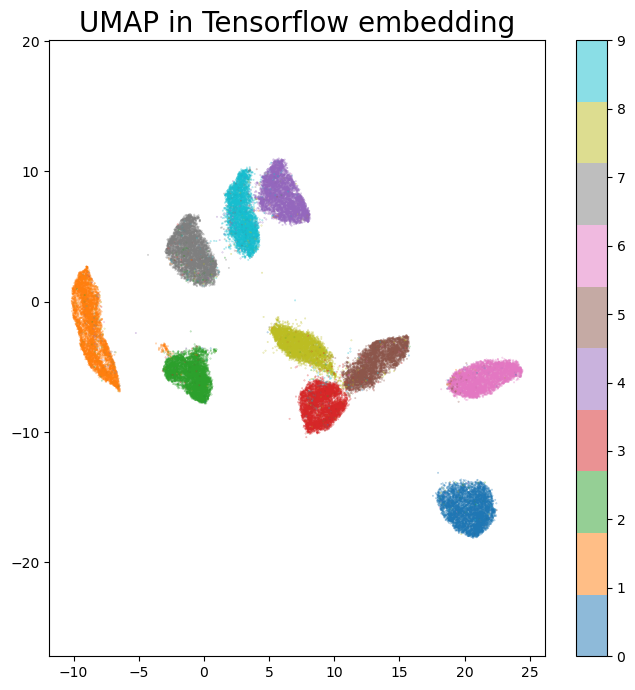

In [9]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=Y_train.astype(int),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### plotting loss

In [10]:
embedder._history.keys()

dict_keys(['loss'])

Text(0.5, 0, 'Epoch')

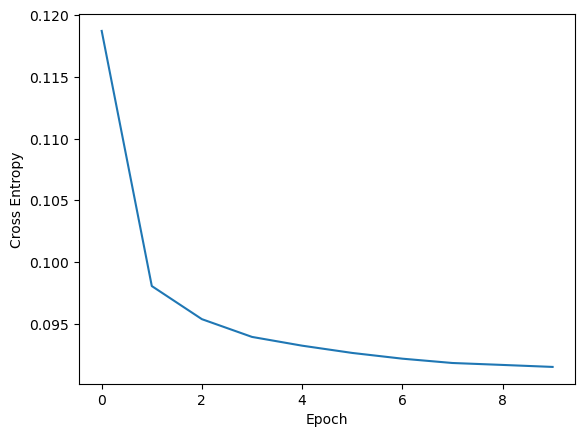

In [11]:
fig, ax = plt.subplots()
ax.plot(embedder._history['loss'])
ax.set_ylabel('Cross Entropy')
ax.set_xlabel('Epoch')

In [27]:
import numpy as np
corners = np.array([
    [5, -1],  # 1
    [15, -1],  # 7
    [5, -10],  # 2
    [15, -10],  # 0
])

test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 10)
    for x in np.linspace(0, 1, 10)
])

inv_transformed_points = embedder.inverse_transform(test_pts)

Epochs completed:   0%|            0/100 [00:00]

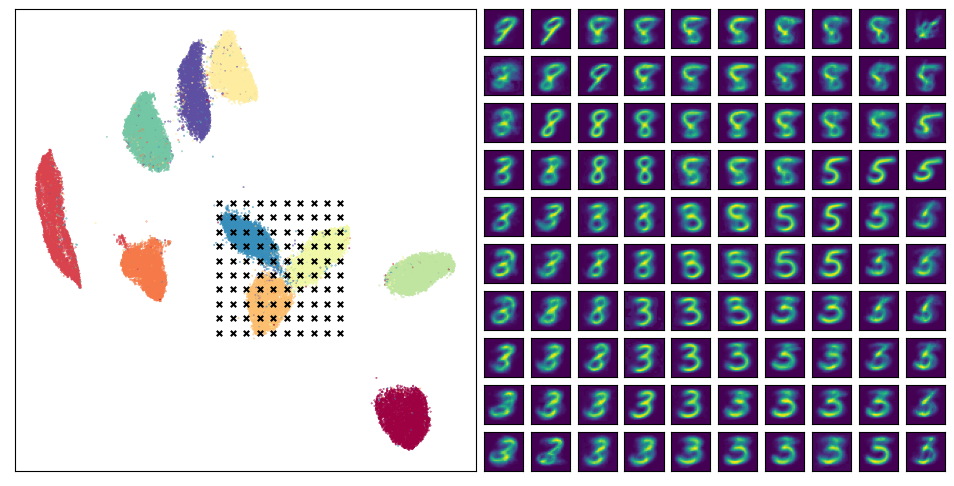

In [28]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(12,6))
gs = GridSpec(10, 20, fig)
scatter_ax = fig.add_subplot(gs[:, :10])
digit_axes = np.zeros((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        digit_axes[i, j] = fig.add_subplot(gs[i, 10 + j])

# Use umap.plot to plot to the major axis
# umap.plot.points(mapper, labels=labels, ax=scatter_ax)
scatter_ax.scatter(embedding[:, 0], embedding[:, 1],
                   c=Y_train.astype(int), cmap='Spectral', s=0.1)
scatter_ax.set(xticks=[], yticks=[])

# Plot the locations of the text points
scatter_ax.scatter(test_pts[:, 0], test_pts[:, 1], marker='x', c='k', s=15)

# Plot each of the generated digit images
for i in range(10):
    for j in range(10):
        digit_axes[i, j].imshow(inv_transformed_points[i*10 + j].reshape(28, 28))
        digit_axes[i, j].set(xticks=[], yticks=[])